In [195]:
# IMPORTS
import re
import numpy as np
import pandas as pd
from pprint import pprint
import zipfile

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
import nltk
nltk.download('stopwords')

In [198]:
path_to_file = 'data/covid-19_discussions/processed/2020-10-11.csv'
path_to_extraction = 'data/covid-19_discussions/'

#### Prepare stop words

In [200]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# drop covid-19
stop_words.extend(['covid-19'])

#### Import data

In [201]:
df = pd.read_csv(path_to_file)
df.head()

,thread_name,categories,replies,views,total_likes,creation_date,first_reply_date,last_reply_date,thread_url,frequent_posters,...,thread_text,thread_images,thread_edits,latest_thread_edit_date,reply_author,reply_likes,reply_text,reply_images,reply_date,crawl_date
0,About the COVID-19 Discussions category,COVID-19 Discussions,25,910,182,"Mar 26, 2020 12:19 pm","Mar 26, 2020 12:40 pm","Sep 19, 2020 2:26 pm",https://forum.fiverr.com/t/about-the-covid-19-...,"mic_explainer, makebossmoves, freelancerbkas, ...",...,I’ve created this category to be a lightning r...,NaN,1.0,"Mar 26, 2020 12:24 pm",mic_explainer,16.0,@mjensen415 may God protect us all\nBasically ...,NaN,"Mar 26, 2020 12:40 pm",2020-10-11 19:18:21.463372
1,About the COVID-19 Discussions category,COVID-19 Discussions,25,910,182,"Mar 26, 2020 12:19 pm","Mar 26, 2020 12:40 pm","Sep 19, 2020 2:26 pm",https://forum.fiverr.com/t/about-the-covid-19-...,"mic_explainer, makebossmoves, freelancerbkas, ...",...,I’ve created this category to be a lightning r...,NaN,1.0,"Mar 26, 2020 12:24 pm",freelancerbkas,18.0,Our country is a densely populated country. Th...,NaN,"Mar 27, 2020 3:15 am",2020-10-11 19:18:21.871712
2,About the COVID-19 Discussions category,COVID-19 Discussions,25,910,182,"Mar 26, 2020 12:19 pm","Mar 26, 2020 12:40 pm","Sep 19, 2020 2:26 pm",https://forum.fiverr.com/t/about-the-covid-19-...,"mic_explainer, makebossmoves, freelancerbkas, ...",...,I’ve created this category to be a lightning r...,NaN,1.0,"Mar 26, 2020 12:24 pm",mic_explainer,8.0,@freelancerbkas You’re from which country?,NaN,"Mar 28, 2020 8:23 am",2020-10-11 19:18:22.260357
3,About the COVID-19 Discussions category,COVID-19 Discussions,25,910,182,"Mar 26, 2020 12:19 pm","Mar 26, 2020 12:40 pm","Sep 19, 2020 2:26 pm",https://forum.fiverr.com/t/about-the-covid-19-...,"mic_explainer, makebossmoves, freelancerbkas, ...",...,I’ve created this category to be a lightning r...,NaN,1.0,"Mar 26, 2020 12:24 pm",freelancerbkas,14.0,I am from Bangladesh.,NaN,"Mar 28, 2020 11:39 am",2020-10-11 19:18:22.671560
4,About the COVID-19 Discussions category,COVID-19 Discussions,25,910,182,"Mar 26, 2020 12:19 pm","Mar 26, 2020 12:40 pm","Sep 19, 2020 2:26 pm",https://forum.fiverr.com/t/about-the-covid-19-...,"mic_explainer, makebossmoves, freelancerbkas, ...",...,I’ve created this category to be a lightning r...,NaN,1.0,"Mar 26, 2020 12:24 pm",mic_explainer,8.0,"OK bro, may God watch over us all! mashallar.",NaN,"Mar 28, 2020 4:32 pm",2020-10-11 19:18:23.065066


In [202]:
print(len(df))

3039


#### Remove newline characters and awkward spaces

In [203]:
# Convert to list
data = df.thread_name.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['About the COVID-19 Discussions category']


#### Tokenize words and Clean-up text

Remove punctuations and unnecessary characters using simple_preprocess()

In [204]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['about', 'the', 'covid', 'discussions', 'category']]


#### Creating Bigram and Trigram Models

In [205]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['about', 'the', 'covid', 'discussions', 'category']


##### Remove Stopwords, Make Bigrams and Lemmatize

In [206]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [207]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['covid', 'discussion', 'category']]


#### Create the Dictionary and Corpus needed for Topic Modeling

In [208]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [209]:
# Term-frequencies
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('category', 1), ('covid', 1), ('discussion', 1)]]

#### Building the Topic Model

In [223]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=200,
                                           alpha='auto',
                                           per_word_topics=True)

#### View the topics in LDA model

In [224]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.263*"due" + 0.066*"discover" + 0.066*"gouge" + 0.066*"price" + '
  '0.050*"effect" + 0.041*"new" + 0.039*"go" + 0.034*"stay" + 0.033*"pandemic" '
  '+ 0.024*"reduce"'),
 (1,
  '0.221*"sale" + 0.151*"maybe" + 0.151*"reason" + 0.086*"help" + '
  '0.067*"fighting" + 0.067*"organization" + 0.025*"stop" + '
  '0.024*"construction" + 0.019*"let" + 0.013*"particluar"'),
 (2,
  '0.257*"impact" + 0.197*"freelance" + 0.095*"work" + 0.073*"else" + '
  '0.073*"distribution" + 0.072*"self" + 0.072*"isolation" + 0.068*"time" + '
  '0.021*"get" + 0.009*"make"'),
 (3,
  '0.271*"freelancer" + 0.167*"fund" + 0.100*"support" + 0.082*"spread" + '
  '0.042*"period" + 0.032*"quarantine" + 0.021*"week" + 0.021*"gonne" + '
  '0.021*"rough" + 0.021*"learn"'),
 (4,
  '0.150*"day" + 0.097*"buy" + 0.068*"join" + 0.067*"service" + 0.063*"buyer" '
  '+ 0.063*"people" + 0.063*"see" + 0.063*"mostly" + 0.035*"mask" + '
  '0.035*"sanitizer"'),
 (5,
  '0.574*"covid" + 0.055*"experience" + 0.034*"kill" + 0.032*

#### Compute Model Perplexity and Coherence Score

In [225]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.9355629072729523

Coherence Score:  0.5558063791597981


#### Visualize the topics-keywords

In [226]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,  mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.052196  0.078755       1        1  18.908138
5     -0.094458 -0.420938       2        1  18.042250
2     -0.424493 -0.150380       3        1  16.784742
6     -0.327526  0.334208       4        1  13.739017
0      0.304844 -0.315641       5        1  13.224188
3      0.418769  0.067587       6        1  12.701023
4      0.175060  0.406409       7        1   6.600645, topic_info=           Term        Freq       Total Category  logprob  loglift
1         covid  855.000000  855.000000  Default  30.0000  30.0000
12       impact  356.000000  356.000000  Default  29.0000  29.0000
6    freelancer  284.000000  284.000000  Default  28.0000  28.0000
66          due  287.000000  287.000000  Default  27.0000  27.0000
11         sale  345.000000  345.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
34         face    0.121116    1.326726   Topic7  -8.4109   0.3243
36         half    0.121116    1.326726   Topic7  -8.4109   0.3243
89          new    0.131268   45.562626   Topic7  -8.3304  -3.1316
179        lone    0.123691    3.060052   Topic7  -8.3898  -0.4904
59       fiverr    0.128373  105.646469   Topic7  -8.3527  -3.9949

[261 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         6  0.936712       able
141       6  0.911810        act
152       1  0.896326    address
230       3  0.681711  advantage
229       2  0.904443     advise
...     ...       ...        ...
212       3  0.898759      weird
151       3  0.995635       work
79        2  0.972441      world
163       1  0.926144      worry
62        4  0.953894      would

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 7, 1, 4, 5])

In [227]:
pyLDAvis.save_html(vis, 'covid-19_discussions.html')

#### Building LDA Mallet Model

In [221]:
mallet_path = 'resources/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)

In [222]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('freelancer', 0.30210325047801145),
   ('support', 0.17877629063097514),
   ('spread', 0.16730401529636713),
   ('game', 0.09177820267686425),
   ('playing', 0.07265774378585087),
   ('situation', 0.02198852772466539),
   ('newcomer', 0.016252390057361378),
   ('market', 0.015296367112810707),
   ('fund', 0.011472275334608031),
   ('breakdown', 0.011472275334608031)]),
 (1,
  [('sale', 0.4116022099447514),
   ('reason', 0.37937384898710863),
   ('covid', 0.15101289134438306),
   ('rough', 0.01289134438305709),
   ('correct', 0.006445672191528545),
   ('rapid', 0.0055248618784530384),
   ('removal', 0.004604051565377533),
   ('utilize', 0.003683241252302026),
   ('bless', 0.003683241252302026),
   ('remady', 0.003683241252302026)]),
 (2,
  [('fiverr', 0.11448834853090173),
   ('time', 0.0911854103343465),
   ('work', 0.08308004052684904),
   ('day', 0.07497467071935157),
   ('buy', 0.0668693009118541),
   ('distribution', 0.06382978723404255),
   ('join', 0.0364741641337386),
 

#### Finding optimal number of topics

In [212]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [216]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

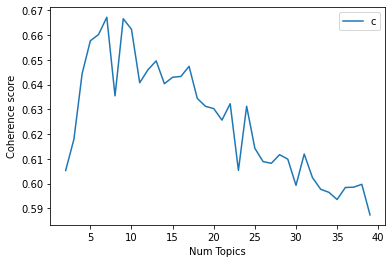

In [218]:
# Graph
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [219]:
dict = {}
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    dict[m] = round(cv,4)
print("Max = " + str(max(dict, key=dict.get)))

Num Topics = 2  has Coherence Value of 0.6053
Num Topics = 3  has Coherence Value of 0.6179
Num Topics = 4  has Coherence Value of 0.6444
Num Topics = 5  has Coherence Value of 0.6577
Num Topics = 6  has Coherence Value of 0.6603
Num Topics = 7  has Coherence Value of 0.6673
Num Topics = 8  has Coherence Value of 0.6355
Num Topics = 9  has Coherence Value of 0.6667
Num Topics = 10  has Coherence Value of 0.6624
Num Topics = 11  has Coherence Value of 0.6408
Num Topics = 12  has Coherence Value of 0.646
Num Topics = 13  has Coherence Value of 0.6496
Num Topics = 14  has Coherence Value of 0.6404
Num Topics = 15  has Coherence Value of 0.643
Num Topics = 16  has Coherence Value of 0.6433
Num Topics = 17  has Coherence Value of 0.6474
Num Topics = 18  has Coherence Value of 0.6344
Num Topics = 19  has Coherence Value of 0.6313
Num Topics = 20  has Coherence Value of 0.6303
Num Topics = 21  has Coherence Value of 0.6257
Num Topics = 22  has Coherence Value of 0.6323
Num Topics = 23  has Co

In [ ]:
# Select the model and print the topics
optimal_model = model_list[18]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
#### Finding the dominant topic in each sentence

In [ ]:
#### Find the most representative document for each topic

In [ ]:
#### Topic distribution across documents